# Setup

In [1]:
!pip install transformers

     |████████████████████████████████| 1.1MB 4.0MB/s 
     |████████████████████████████████| 3.0MB 10.3MB/s 
     |████████████████████████████████| 890kB 13.4MB/s 
     |████████████████████████████████| 1.1MB 15.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=14cce42745b7054f2e6be552a1209f243dcbef9fd71d7434bb9068351626cbe1
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import torch
import time
import datetime
import io

from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from google.colab import drive
from google.colab import files

In [3]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

import gc

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=5c1aee25b6785604c456d13e29fb39155978bc91c52504259cc9591964c7e7c3
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [4]:
from google.colab import files
src = list(files.upload().values())[0]
open('mylib.py','wb').write(src)
import mylib

Saving transformers_model.py to transformers_model.py
Saving classification_analysis.py to classification_analysis.py
Saving bert_tokenizer.py to bert_tokenizer.py


In [5]:
import transformers_model
import bert_tokenizer
import classification_analysis

In [6]:
## GPU google colab
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df = pd.read_csv('drive/My Drive/TCC/Scores/scores_tmp.csv', sep='\t')

# Code

## Making Dataset

In [9]:
df_cleaned = df[df['comment'].notnull()].reset_index()#.loc[:2000,:]
df_cleaned = pd.concat([df_cleaned[df_cleaned['label'] == 1], df_cleaned[df_cleaned['label'] == 0].loc[:2000, :]])
df_cleaned = df_cleaned.sample(frac=1)

In [10]:
sentences = df_cleaned['comment'].tolist()
labels = df_cleaned['label'].tolist()

seed_val = 42
np.random.seed(seed_val)

torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [11]:
input_ids, attention_masks, labels = bert_tokenizer.make_dataset(sentences, labels, max_phrase_len=250)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Model Tunning

In [12]:
cross_val_train_percentage = 0.7
epochs = 4
batch_size=32
epochs=4
learning_rate=2e-5
epsilon=1e-8

In [13]:
training_stats, model = transformers_model.model_training(input_ids, attention_masks, labels, device, batch_size=batch_size,
                                             epochs=epochs, learning_rate=learning_rate, epsilon=epsilon)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

2,105 training samples
  903 validation samples

======== Epoch 1 / 4 ========
Training...
Gen RAM Free: 9.3 GB  |     Proc size: 5.3 GB
GPU RAM Free: 3740MB | Used: 11339MB | Util  75% | Total     15079MB
 Average training loss: 0.65

Running Validation...
Gen RAM Free: 9.3 GB  |     Proc size: 5.3 GB
GPU RAM Free: 3740MB | Used: 11339MB | Util  75% | Total     15079MB
 Accuracy: 0.66
 Validation Loss: 0.63

======== Epoch 2 / 4 ========
Training...
Gen RAM Free: 9.3 GB  |     Proc size: 5.3 GB
GPU RAM Free: 3740MB | Used: 11339MB | Util  75% | Total     15079MB
 Average training loss: 0.60

Running Validation...
Gen RAM Free: 9.3 GB  |     Proc size: 5.3 GB
GPU RAM Free: 3740MB | Used: 11339MB | Util  75% | Total     15079MB
 Accuracy: 0.69
 Validation Loss: 0.60

======== Epoch 3 / 4 ========
Training...
Gen RAM Free: 9.3 GB  |     Proc size: 5.3 GB
GPU RAM Free: 3740MB | Used: 11339MB | Util  75% | Total     15079MB
 Average training loss: 0.52

Running Validation...
Gen RAM Free: 

## Test Set preparing

In [14]:
test_set = df[df['comment'].notnull()]
test_set = pd.concat([test_set[test_set['label'] == 1].reset_index().loc[0:500],
                      test_set[test_set['label'] == 0].reset_index().loc[0:500]])
test_set = test_set.sample(frac=1).reset_index().drop(columns=['level_0', 'index'])

In [15]:
prediction_dataloader = transformers_model.load_test_set(test_set)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Execute prediction

In [16]:
flat_predictions, flat_true_labels = transformers_model.run_model(model, prediction_dataloader, device)

In [17]:
flat_predictions

array([0, 0, 0, ..., 0, 1, 1])

In [18]:
flat_true_labels

array([0, 0, 0, ..., 0, 1, 1])

## Compile Results

In [19]:
compiled_results = classification_analysis.compile_results(flat_predictions, flat_true_labels, test_set)

In [ ]:
# compiled_results.to_csv('compiled_results.csv', sep='\t')
# files.download('tmp_output.csv')

# Analysis

In [21]:
results, conf_mat = classification_analysis.get_test_set_analysis(compiled_results)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
results

,label_0,label_1,complete_dataset
accuracy,0.888224,0.608782,0.748503
balanced_acc,0.888224,0.608782,0.748503
precision_score,0.000000,1.000000,0.844875
recall,0.000000,0.608782,0.608782
f1_score,0.000000,0.756824,0.707657


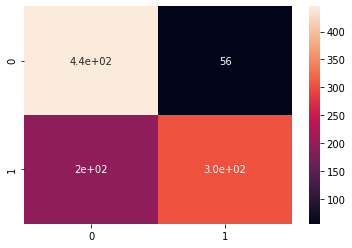

In [25]:
sns.heatmap(conf_mat, annot=True)

## End (kill execution)

In [ ]:
gc.collect()
print_gpu_space()
torch.cuda.empty_cache()
!kill -9 -1